In [1]:
import csv
import pandas as pd
dataset=pd.read_csv('data1.csv')

In [2]:
dataset.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


In [3]:
dataset.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64

In [4]:
dataset.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
liked                 int64
dtype: object

In [5]:
import numpy as np
import warnings
warnings.filterwarnings("ignore") #suppress warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#convert imput to numpy arrays
X = dataset.drop(columns=['key'])



y_label = dataset['key'].values.reshape(X.shape[0], 1)

#split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (156, 13)
Shape of test set is (39, 13)
Shape of train label is (156, 1)
Shape of test labels is (39, 1)


In [6]:
class NeuralNet():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu(self,Z):
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)


    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))
    def sigmoid_der(self,Z):
        return self.sigmoid(Z) *(1-self.sigmoid(Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) ## clips value to avoid NaNs in log
        yhat_inv = self.eta(yhat_inv) 
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss
    
    def back_propagation(self,yhat):
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)
    
    
    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc
    

    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  

In [7]:
nn = NeuralNet() # create the NN model
nn.fit(Xtrain, ytrain) #train the model

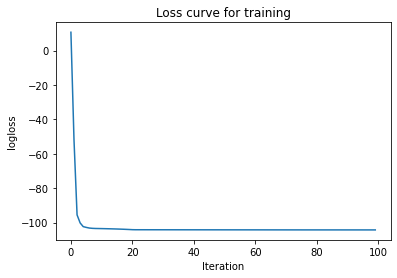

In [8]:
nn.plot_loss()

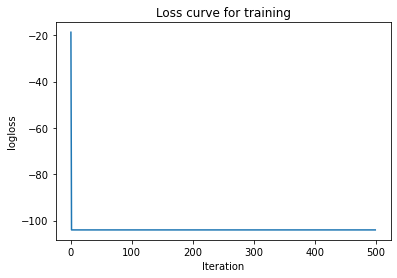

In [9]:
nn = NeuralNet(layers=[13,10,1], learning_rate=0.01, iterations=500) # create the NN model
nn.fit(Xtrain, ytrain) #train the model
nn.plot_loss()


In [10]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)
print("Train accuracy is {0}%".format(np.round(nn.acc(ytrain, train_pred)),decimals=2))
print("Test accuracy is {0}%".format(np.round(nn.acc(ytest,test_pred)),decimals=2))

Train accuracy is 13%
Test accuracy is 23%


In [11]:
np.log(np.NaN)

nan